# Teste

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
import random
import torch

from bayesian_nn import BayesianNN
from nn_methods import NeuralNetworkMethods

In [2]:
%matplotlib inline

## Carregando o Dataset

In [3]:
dataset = pd.read_csv('dataset/pima.csv')
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### Normalização da base de dados e separação em treino e teste

In [4]:
random.seed(30)
min_max_scaler = MinMaxScaler()
values = dataset.values
random.shuffle(values)
normalized_X = min_max_scaler.fit_transform(values[:,0:-1])
y = values[:,-1]
batched_datasets = []

for i in range(3,9,1):
    X_new = SelectKBest(chi2, k=i).fit_transform(normalized_X, y)
    dataset_values = np.split(X_new, 48)
    dataset_labels = np.split(y.astype(int), 48)
    batched_dataset = []
    for i in range(len(dataset_labels)):
        batched_dataset.append([torch.tensor(dataset_values[i]), torch.tensor(dataset_labels[i])])
    train_data = batched_dataset[:30]
    test_data = batched_dataset[30:]
    batched_datasets.append({'train': train_data, 'test': test_data})
    
#dataset_values = np.split(min_max_scaler.fit_transform(dataset.values[:,0:-1].astype(float)), 48)
#dataset_labels = np.split(dataset.values[:,-1].astype(int), 48)


In [5]:
dataset_batched = []

for i in range(len(dataset_labels)):
    dataset_batched.append([torch.tensor(dataset_values[i]), torch.tensor(dataset_labels[i])])
random.seed(30)
random.shuffle(dataset_batched)
train_data = dataset_batched[:30]
test_data = dataset_batched[30:]

## Criando as Redes Neurais

In [6]:
neural_networks = []
for i in range(3,9,1):
    neural_networks.append(NeuralNetworkMethods(i,4,2,i-2))

## Treinando

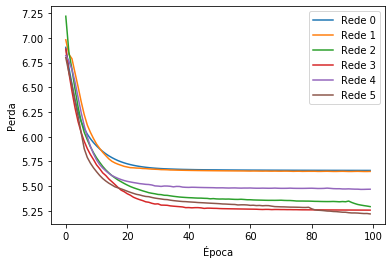

In [7]:
for i in range(len(neural_networks)):
    dataset_size = len(batched_datasets[i]['train']) + len(batched_datasets[i]['test'])
    losses = neural_networks[i].train(batched_datasets[i]['train'], dataset_size, 100)
    plt.plot(range(100), losses, label=("Rede " + str(i)))
    #plt.title("Rede " + str(i))
plt.legend(loc='upper right')
plt.xlabel("Época")
plt.ylabel("Perda")
plt.show()

## Testando

In [8]:
for i in range(len(neural_networks)):
    correct = 0
    total = 0
    for j, data in enumerate(batched_datasets[i]['test']):
        atributes, labels = data
        predicted = neural_networks[i].predict(atributes.float(), 200)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print("Acuracia: %d %%" % (100 * correct / total))



Acuracia: 72 %
Acuracia: 70 %
Acuracia: 75 %
Acuracia: 75 %
Acuracia: 71 %
Acuracia: 77 %
